# Indicator Association Analysis

This notebook analyzes which technical indicators are most associated with the **trade** class (vs hold) using:

- **Chi-Square Test**: Statistical dependence
- **Mutual Information**: Information content
- **Point-Biserial Correlation**: Binary-binary correlation
- **Fisher's Exact Test**: Precise 2x2 contingency
- **Apriori Association Rules**: Indicator combinations

Results can be exported as a **feature mask** for LSTM feature selection.

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from crypto_analysis import IndicatorAssociationAnalyzer

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Data

In [3]:
# Load the DOGE dataset
df = pd.read_csv('doge.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['tradeable'].value_counts())
print(f"\nTrade percentage: {(df['tradeable'] == 'trade').mean():.2%}")

Dataset shape: (2388, 124)

Class distribution:
tradeable
hold     2052
trade     336
Name: count, dtype: int64

Trade percentage: 14.07%


In [3]:
# Show indicator columns
indicator_cols = [col for col in df.columns if col.endswith(('_gs_entry', '_gs_exit'))]
print(f"Number of indicator columns: {len(indicator_cols)}")
print(f"\nFirst 10 indicators:")
for col in indicator_cols[:10]:
    print(f"  - {col}")

Number of indicator columns: 114

First 10 indicators:
  - TRIX_gs_entry
  - TRIX_gs_exit
  - BOP_gs_entry
  - BOP_gs_exit
  - MOM_gs_entry
  - MOM_gs_exit
  - ROC_gs_entry
  - ROC_gs_exit
  - AROON_gs_entry
  - AROON_gs_exit


## 2. Initialize Analyzer

In [4]:
# Create analyzer
analyzer = IndicatorAssociationAnalyzer(
    df=df,
    target_col='tradeable',
    positive_class='trade'
)

# Print quick summary
analyzer.print_summary(top_k=15)

INDICATOR ASSOCIATION ANALYSIS SUMMARY

Dataset: 2388 samples
  - Trade: 336
  - Hold: 2052

Total features: 114
  - Chi² significant (p<0.05): 67
  - Fisher significant (p<0.05): 75
  - Lift > 1.0: 54
  - Lift > 1.5: 19

Top 15 Trade-Associated Indicators:
------------------------------------------------------------
   1. ATR_gs_entry              score=1.0000 lift=3.21
   2. WILLR_gs_exit             score=0.7119 lift=1.83
   3. STOCH_gs_exit             score=0.7091 lift=1.80
   4. STOCHF_gs_exit            score=0.6852 lift=1.77
   5. CMO_gs_exit               score=0.6622 lift=1.89
   6. CCI_gs_exit               score=0.6593 lift=1.70
   7. RSI_gs_exit               score=0.6491 lift=1.61
   8. STOCHRSI_gs_exit          score=0.5805 lift=1.49
   9. ULTOSC_gs_exit            score=0.5460 lift=1.70
  10. HT_TRENDLINE_gs_entry     score=0.5331 lift=2.28
  11. EMA_gs_exit               score=0.5187 lift=2.51
  12. MACDFIX_gs_entry          score=0.5157 lift=2.32
  13. STOCHRSI_gs_ent

c:\Users\irisbridge\Desktop\projects\freqtrade\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


## 3. Statistical Analysis

In [5]:
# Compute all statistics
stats_df = analyzer.compute_all_statistics()

# Display top 20 features
print("Top 20 Trade-Associated Indicators:")
stats_df[['feature', 'composite_score', 'chi2_statistic', 'mutual_info', 'lift', 'trade_support']].head(20)

Top 20 Trade-Associated Indicators:


,feature,composite_score,chi2_statistic,mutual_info,lift,trade_support
76,ATR_gs_entry,1.000000,157.667885,0.026302,3.210841,0.264881
93,WILLR_gs_exit,0.711929,78.496360,0.021357,1.827551,0.535714
87,STOCH_gs_exit,0.709086,77.084117,0.021504,1.803596,0.550595
103,STOCHF_gs_exit,0.685164,71.664778,0.020190,1.769573,0.547619
33,CMO_gs_exit,0.662175,70.407815,0.016946,1.887428,0.431548
89,CCI_gs_exit,0.659292,64.616421,0.019243,1.701461,0.571429
73,RSI_gs_exit,0.649071,58.200502,0.020066,1.607217,0.648810
107,STOCHRSI_gs_exit,0.580451,42.721778,0.016449,1.491055,0.675595
21,ULTOSC_gs_exit,0.546031,43.921836,0.010823,1.696461,0.392857
52,HT_TRENDLINE_gs_entry,0.533097,34.152153,0.005995,2.276507,0.122024


In [6]:
# Chi-Square results
chi2_df = analyzer.compute_chi_square()
print(f"\nChi-Square Significant Features (p < 0.05): {sum(chi2_df['chi2_pvalue'] < 0.05)}")
print(f"Chi-Square Highly Significant (p < 0.01): {sum(chi2_df['chi2_pvalue'] < 0.01)}")


Chi-Square Significant Features (p < 0.05): 67
Chi-Square Highly Significant (p < 0.01): 54


In [7]:
# Mutual Information results
mi_df = analyzer.compute_mutual_information()
print(f"\nMutual Information Statistics:")
print(f"  Mean: {mi_df['mutual_info'].mean():.4f}")
print(f"  Max:  {mi_df['mutual_info'].max():.4f}")
print(f"  Min:  {mi_df['mutual_info'].min():.4f}")


Mutual Information Statistics:
  Mean: 0.0040
  Max:  0.0263
  Min:  0.0000


## 4. Visualizations

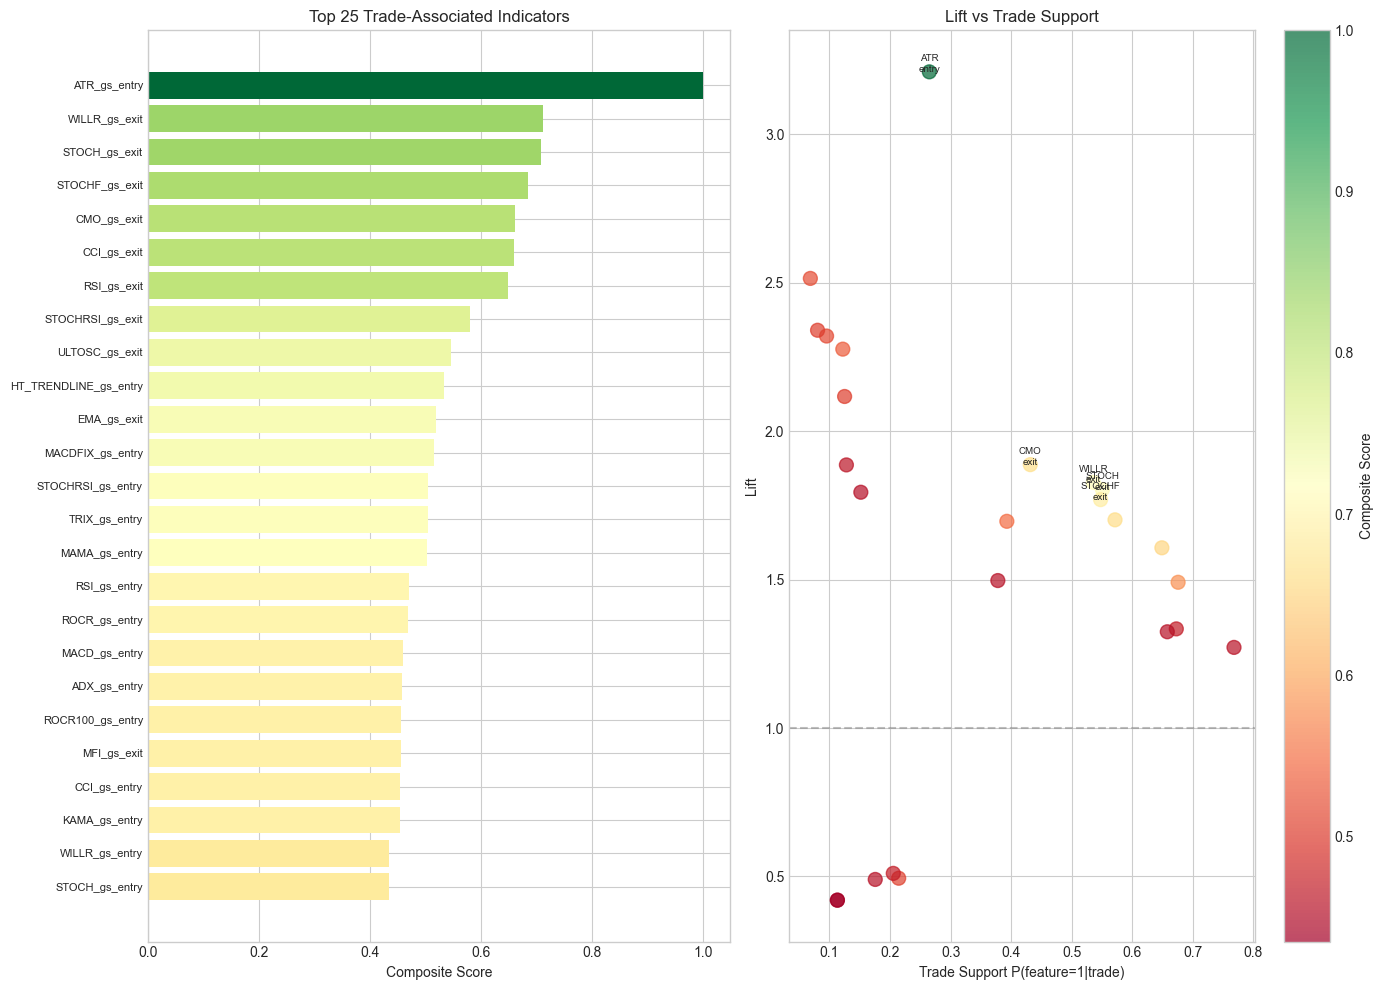

In [8]:
# Feature importance plot
analyzer.plot_feature_importance(top_k=25, figsize=(14, 10))
plt.show()

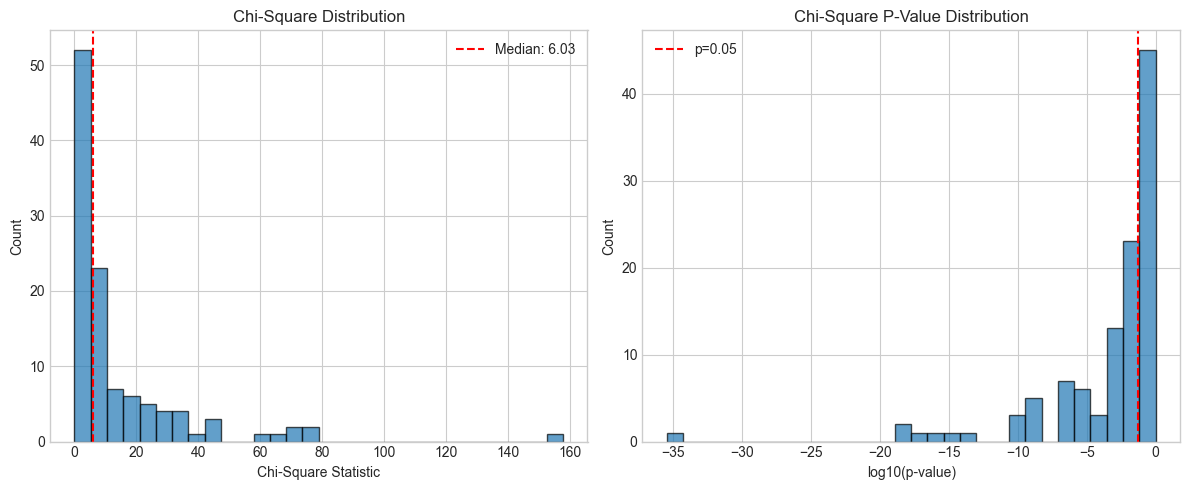

In [9]:
# Chi-Square distribution
analyzer.plot_chi_square_distribution(figsize=(12, 5))
plt.show()

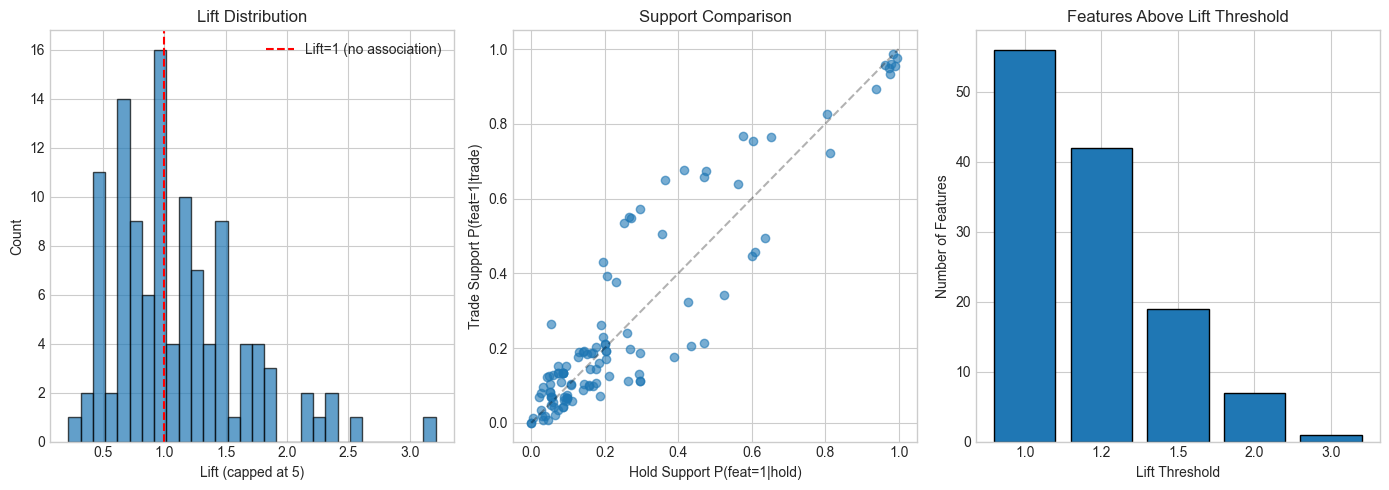

In [10]:
# Lift analysis
analyzer.plot_lift_analysis(figsize=(14, 5))
plt.show()

## 5. Association Rule Mining

Find indicator combinations that predict the **trade** class.

In [25]:
# Mine association rules
rules = analyzer.mine_association_rules(
    min_support=0.005,
    min_confidence=0.2,
    min_lift=1.0,
    max_antecedent_len=3,
    max_rules=500,
    top_k_features=100,
    max_itemsets=900000  # default, can increase if needed
)


print(f"Found {len(rules)} association rules\n")

# Display top rules
print("Top 15 Association Rules (by lift):")
print("-" * 80)
for i, rule in enumerate(rules[:15]):
    ant_str = " + ".join(rule.antecedent)
    print(f"{i+1:2d}. {ant_str}")
    print(f"    -> trade  (support={rule.support:.4f}, confidence={rule.confidence:.3f}, lift={rule.lift:.2f})")
    print()

Using top 100 features for association rule mining
Found 977165 frequent itemsets
Keeping only highest support itemsets to prevent memory issues
Found 500 association rules

Top 15 Association Rules (by lift):
--------------------------------------------------------------------------------
 1. HT_DCPERIOD_gs_exit + MACDEXT_gs_exit + PLUS_DM_gs_entry
    -> trade  (support=0.0067, confidence=0.364, lift=2.58)

 2. MACDEXT_gs_exit + OBV_gs_entry + ROCR100_gs_exit
    -> trade  (support=0.0059, confidence=0.341, lift=2.42)

 3. CCI_gs_exit + HT_DCPERIOD_gs_exit + MACDEXT_gs_exit
    -> trade  (support=0.0067, confidence=0.340, lift=2.42)

 4. CCI_gs_entry + DX_gs_entry + KAMA_gs_exit
    -> trade  (support=0.0071, confidence=0.340, lift=2.41)

 5. AROONOSC_gs_entry + DX_gs_entry + HT_DCPERIOD_gs_exit
    -> trade  (support=0.0076, confidence=0.340, lift=2.41)

 6. AROON_gs_entry + DX_gs_entry + HT_DCPERIOD_gs_exit
    -> trade  (support=0.0076, confidence=0.340, lift=2.41)

 7. DX_gs_entr

In [26]:
# Association network visualization
try:
    analyzer.plot_association_network(min_lift=1.2, max_rules=40, figsize=(14, 12))
    plt.show()
except Exception as e:
    print(f"Network plot requires networkx: {e}")

Found 851016 frequent itemsets
Keeping only highest support itemsets to prevent memory issues
No rules with 'trade' as consequent found
No rules found with min_lift=1.2


## 6. Entry vs Exit Signal Analysis

Compare entry signals vs exit signals for each indicator.

In [27]:
# Group by indicator (combining entry/exit)
indicator_scores = {}

for _, row in stats_df.iterrows():
    feat = row['feature']
    # Extract indicator name (remove _gs_entry or _gs_exit suffix)
    if '_gs_entry' in feat:
        ind_name = feat.replace('_gs_entry', '')
        signal_type = 'entry'
    elif '_gs_exit' in feat:
        ind_name = feat.replace('_gs_exit', '')
        signal_type = 'exit'
    else:
        continue
    
    if ind_name not in indicator_scores:
        indicator_scores[ind_name] = {'entry': 0, 'exit': 0}
    indicator_scores[ind_name][signal_type] = row['composite_score']

# Convert to DataFrame
ind_df = pd.DataFrame(indicator_scores).T
ind_df['combined'] = ind_df['entry'] + ind_df['exit']
ind_df['entry_dominant'] = ind_df['entry'] > ind_df['exit']
ind_df = ind_df.sort_values('combined', ascending=False)

print("Top 20 Indicators (entry + exit combined score):")
ind_df.head(20)

Top 20 Indicators (entry + exit combined score):


,entry,exit,combined,entry_dominant
ADX,0.790910,0.643152,1.434063,True
ADXR,0.686926,0.673811,1.360737,True
DX,0.686175,0.577292,1.263466,True
TRANGE,0.583735,0.416211,0.999947,True
NATR,0.422835,0.503760,0.926595,False
PLUS_DI,0.685794,0.220769,0.906563,True
HT_DCPERIOD,0.117760,0.780503,0.898263,False
ATR,0.286603,0.565209,0.851812,False
ADOSC,0.385815,0.439681,0.825496,False
HT_DCPHASE,0.450700,0.307810,0.758511,True


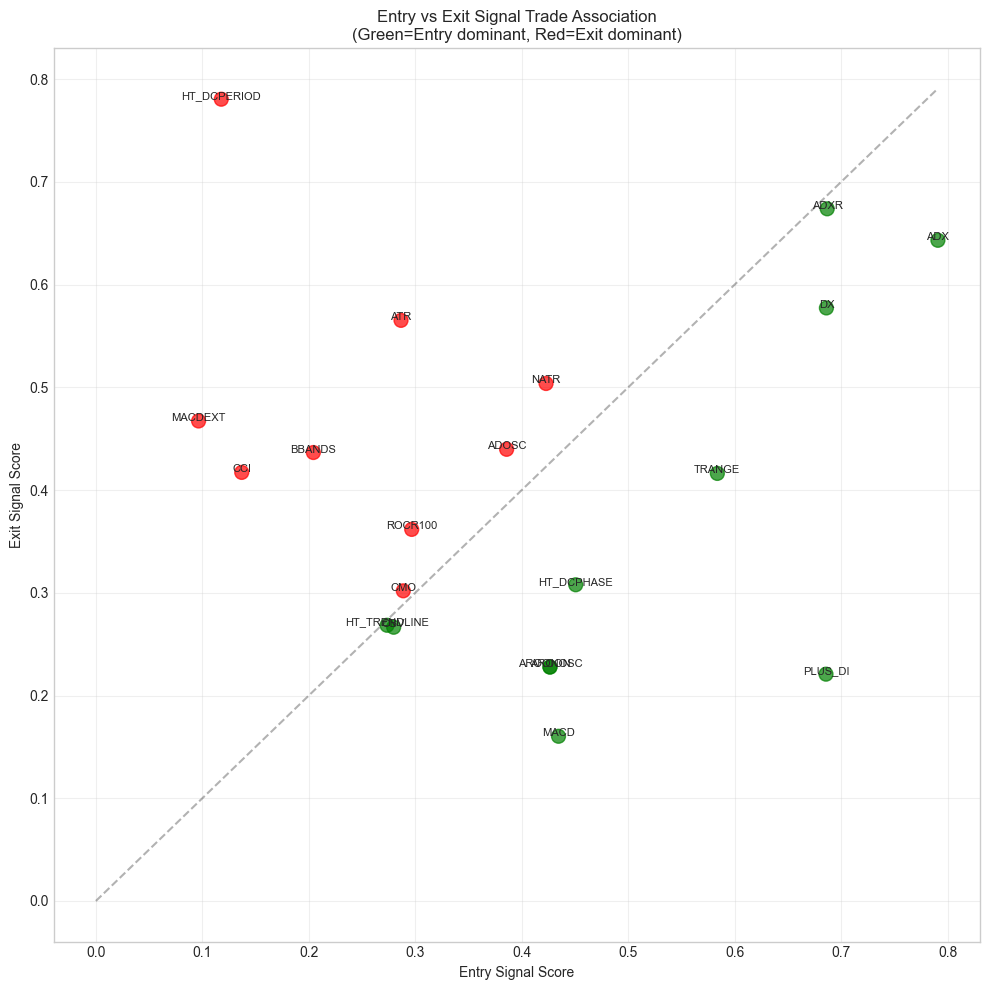

In [28]:
# Plot entry vs exit
fig, ax = plt.subplots(figsize=(10, 10))

top_20 = ind_df.head(20)
colors = ['green' if x else 'red' for x in top_20['entry_dominant']]

ax.scatter(top_20['entry'], top_20['exit'], c=colors, s=100, alpha=0.7)

# Add labels
for idx, row in top_20.iterrows():
    ax.annotate(idx, (row['entry'], row['exit']), fontsize=8, ha='center')

# Diagonal line
max_val = max(top_20['entry'].max(), top_20['exit'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

ax.set_xlabel('Entry Signal Score')
ax.set_ylabel('Exit Signal Score')
ax.set_title('Entry vs Exit Signal Trade Association\n(Green=Entry dominant, Red=Exit dominant)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Complete Analysis Result

In [31]:
# Run complete analysis
result = analyzer.analyze_all(
    min_support=0.005,
    min_confidence=0.2,
    min_lift=1.0,
    max_antecedent_len=3
)

print(f"Analysis complete!")
print(f"  - Feature statistics: {len(result.feature_statistics)} features")
print(f"  - Association rules: {len(result.association_rules)} rules")
print(f"  - Top indicators: {len(result.top_trade_indicators)}")
print(f"  - Indicator combinations: {len(result.indicator_combinations)}")

Found 1295914 frequent itemsets
Keeping only highest support itemsets to prevent memory issues
Analysis complete!
  - Feature statistics: 114 features
  - Association rules: 1000 rules
  - Top indicators: 20
  - Indicator combinations: 20


In [32]:
# Top trade indicators
print("Top 20 Trade-Associated Indicators:")
for i, ind in enumerate(result.top_trade_indicators[:20]):
    print(f"  {i+1:2d}. {ind}")

Top 20 Trade-Associated Indicators:
   1. ADX_gs_entry
   2. HT_DCPERIOD_gs_exit
   3. ADXR_gs_entry
   4. DX_gs_entry
   5. PLUS_DI_gs_entry
   6. ADXR_gs_exit
   7. ADX_gs_exit
   8. TRANGE_gs_entry
   9. DX_gs_exit
  10. ATR_gs_exit
  11. NATR_gs_exit
  12. MACDEXT_gs_exit
  13. HT_DCPHASE_gs_entry
  14. ADOSC_gs_exit
  15. BBANDS_gs_exit
  16. MACD_gs_entry
  17. AROONOSC_gs_entry
  18. AROON_gs_entry
  19. NATR_gs_entry
  20. MINUS_DI_gs_entry


In [33]:
# Best indicator combinations
print("\nBest Indicator Combinations (from association rules):")
for i, combo in enumerate(result.indicator_combinations[:15]):
    print(f"  {i+1:2d}. {' + '.join(combo)}")


Best Indicator Combinations (from association rules):
   1. CCI_gs_exit + HT_DCPERIOD_gs_exit + ROCR100_gs_exit
   2. ADX_gs_entry + AROON_gs_entry + HT_DCPERIOD_gs_exit
   3. ADX_gs_entry + AROONOSC_gs_entry + HT_DCPERIOD_gs_exit
   4. AROON_gs_entry + HT_DCPERIOD_gs_exit + ROCR_gs_entry
   5. AROONOSC_gs_entry + HT_DCPERIOD_gs_exit + ROCR_gs_entry
   6. AROON_gs_entry + HT_DCPERIOD_gs_exit + ROCR100_gs_entry
   7. AROONOSC_gs_entry + HT_DCPERIOD_gs_exit + ROCR100_gs_entry
   8. ADXR_gs_entry + AROON_gs_entry + HT_DCPERIOD_gs_exit
   9. ADXR_gs_entry + AROONOSC_gs_entry + HT_DCPERIOD_gs_exit
  10. ROCR100_gs_exit + STOCHRSI_gs_exit + TRANGE_gs_entry
  11. DEMA_gs_entry + ROCR100_gs_exit + TRANGE_gs_entry
  12. ADX_gs_exit + HT_DCPHASE_gs_entry + TRANGE_gs_entry
  13. ADX_gs_entry + STOCHF_gs_entry + T3_gs_exit
  14. CCI_gs_exit + HT_DCPERIOD_gs_exit + OBV_gs_entry
  15. ADX_gs_entry + AD_gs_exit + MINUS_DM_gs_exit


## 8. Export for LSTM

Export results as feature mask for `LSTMMetaheuristicOptimizer`.

In [34]:
# Generate feature mask (top 50% of features)
feature_mask = analyzer.get_feature_mask(percentile=50.0)

print(f"Feature mask shape: {feature_mask.shape}")
print(f"Selected features: {feature_mask.sum()} / {len(feature_mask)}")
print(f"Selection ratio: {feature_mask.mean():.2%}")

Feature mask shape: (114,)
Selected features: 57 / 114
Selection ratio: 50.00%


In [35]:
# Export full results for LSTM
lstm_export = analyzer.export_for_lstm(percentile=50.0, top_k=30)

print("LSTM Export Contents:")
for key, value in lstm_export.items():
    if isinstance(value, list):
        print(f"  {key}: {len(value)} items")
    elif isinstance(value, dict):
        print(f"  {key}: {len(value)} entries")
    else:
        print(f"  {key}: {value}")

Found 851016 frequent itemsets
No rules with 'trade' as consequent found
LSTM Export Contents:
  feature_columns: 114 items
  feature_mask: 114 items
  feature_scores: 114 entries
  top_features: 30 items
  top_feature_indices: 30 items
  indicator_combinations: 0 items
  class_distribution: 2 entries
  percentile_threshold: 50.0


In [36]:
# Show selected features
print("\nSelected Features (mask=1):")
selected_features = [f for f, m in zip(lstm_export['feature_columns'], lstm_export['feature_mask']) if m == 1]
for i, feat in enumerate(selected_features[:30]):
    print(f"  {i+1:2d}. {feat}")

if len(selected_features) > 30:
    print(f"  ... and {len(selected_features) - 30} more")


Selected Features (mask=1):
   1. TRIX_gs_entry
   2. TRIX_gs_exit
   3. BOP_gs_entry
   4. BOP_gs_exit
   5. ROC_gs_entry
   6. ROC_gs_exit
   7. MOM_gs_entry
   8. MOM_gs_exit
   9. AROON_gs_entry
  10. AROON_gs_exit
  11. AROONOSC_gs_entry
  12. AROONOSC_gs_exit
  13. APO_gs_entry
  14. APO_gs_exit
  15. PPO_gs_entry
  16. PPO_gs_exit
  17. MACDFIX_gs_entry
  18. MACDFIX_gs_exit
  19. MINUS_DM_gs_entry
  20. MINUS_DM_gs_exit
  21. ULTOSC_gs_entry
  22. ULTOSC_gs_exit
  23. MACD_gs_entry
  24. MACD_gs_exit
  25. ROCP_gs_entry
  26. ROCP_gs_exit
  27. PLUS_DM_gs_entry
  28. PLUS_DM_gs_exit
  29. MACDEXT_gs_entry
  30. MACDEXT_gs_exit
  ... and 27 more


In [37]:
# Save export to JSON
import json

export_path = 'indicator_association_export.json'
with open(export_path, 'w') as f:
    json.dump(lstm_export, f, indent=2)

print(f"Export saved to: {export_path}")

TypeError: Object of type int64 is not JSON serializable

## 9. Generate Report

In [ ]:
# Generate markdown report
analyzer.generate_report('indicator_association_report.md', format='markdown', top_k=30)

# Generate JSON report
analyzer.generate_report('indicator_association_report.json', format='json', top_k=30)

## 10. Usage with LSTMMetaheuristicOptimizer

Example of how to use the feature mask with LSTM optimization:

In [7]:
# Example usage (uncomment to run)

from crypto_analysis import LSTMMetaheuristicOptimizer

# Get feature mask (top 60% of features)
feature_mask = analyzer.get_feature_mask(percentile=40.0)  # Select top 60%

# Use mask to filter features before LSTM training
feature_cols = analyzer.feature_cols
selected_cols = [col for col, mask in zip(feature_cols, feature_mask) if mask == 1]

# Create filtered dataset
lstm_df = df[['date', 'tradeable'] + selected_cols].copy()

# Run LSTM optimization on filtered features
optimizer = LSTMMetaheuristicOptimizer(
    df=lstm_df,
    model_type='cnn_lstm',
    pop_size=12,              # +2: Better exploration
    iterations=70,            # +20: Still improving, allow more time
    n_workers=15,
    np_neighbors=2,           # +1: Better neighborhood effect
    pf_max=0.18,              # +0.03: More exploration (params diverse)
    epochs_per_eval=100,
    checkpoint_interval=5,
    elitist_selection=True,
    elitist_constant=0.15,    # -0.02: Slightly more exploration
    verbose=True,
    enable_logging=True,
)

result = optimizer.optimize()
result

LSTMMetaheuristicOptimizer (APO) initialized:
  - Model type: cnn_lstm
  - DataFrame mode: binary
  - Feature columns: 68
  - Hyperparameters: 13
  - Total dimension: 81
  - Population size: 12
  - Iterations: 70
  - Workers: 15
  - APO np_neighbors: 2
  - APO pf_max: 0.18
  - Elitist selection: True
  - Elitist constant: 0.15
  - Correlation vector: min=0.0000, max=0.1955, mean=0.0590

Starting APO Metaheuristic Optimization
Run ID: 6064e65d

Evaluating initial population...
iter:-1 indv:10 fitness:0.0710 features:33
iter:-1 indv:6 fitness:0.0209 features:33
iter:-1 indv:1 fitness:0.0838 features:43
iter:-1 indv:5 fitness:0.1300 features:30
iter:-1 indv:7 fitness:0.0000 features:35
iter:-1 indv:11 fitness:0.0628 features:41
iter:-1 indv:0 fitness:0.0000 features:35
iter:-1 indv:9 fitness:0.0000 features:32
iter:-1 indv:8 fitness:0.1703 features:33
iter:-1 indv:4 fitness:0.1232 features:36
iter:-1 indv:3 fitness:0.0000 features:30
iter:-1 indv:2 fitness:0.0000 features:35

------------

KeyboardInterrupt: 

## Summary

This analysis identified:
1. **Individual indicators** most associated with trade class (via chi-square, MI, lift)
2. **Indicator combinations** that predict trade (via association rules)
3. **Feature mask** for LSTM feature selection

Key outputs:
- `indicator_association_export.json`: Feature mask and scores for LSTM
- `indicator_association_report.md`: Human-readable analysis report